# Домашнее задание "Варианционные автоэнкодеры"


В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.



     

Установите библиотеку для подсчета FID:

In [ ]:
%pip install pytorch-fid

## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используем устройство: {device}')

Используем устройство: cuda


### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [4]:
# Гиперпараметры
BATCH_SIZE = 512

# Загрузка датасета
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'Размер тренировочного набора: {len(train_dataset)}')
print(f'Размер тестового набора: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.64MB/s]

Размер тренировочного набора: 60000
Размер тестового набора: 10000


**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [5]:
# Сохранение 10k реальных изображений из MNIST test для FID
output_dir = 'mnist_vae_real'
os.makedirs(output_dir, exist_ok=True)

idx = 0
for images, labels in tqdm(test_loader, desc='Сохранение реальных изображений'):
    for img in images:
        if idx >= 10000:
            break
        # Конвертируем в RGB для FID (Inception требует 3 канала)
        img_rgb = img.repeat(3, 1, 1)
        save_image(img_rgb, os.path.join(output_dir, f'{idx:05d}.png'))
        idx += 1
    if idx >= 10000:
        break

print(f'Сохранено {idx} реальных изображений в {output_dir}')

Сохранение реальных изображений:  95%|█████████▌| 19/20 [00:05<00:00,  3.51it/s]

Сохранено 10000 реальных изображений в mnist_vae_real


**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

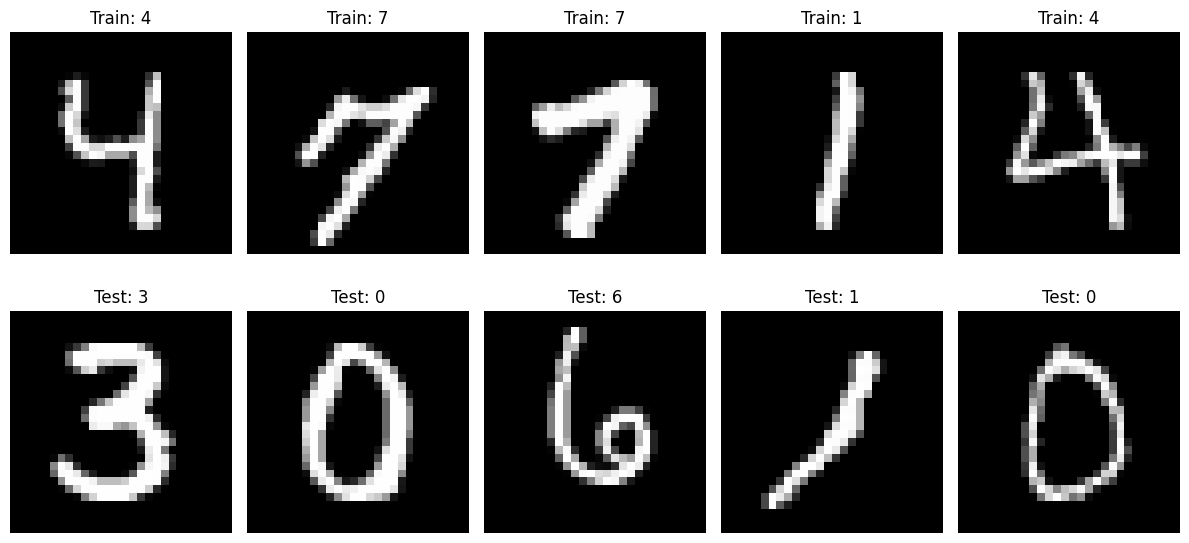

In [6]:
# Визуализация 5 рандомных сэмплов из тренировочных и тестовых данных
num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))

# Рандомные индексы
train_indices = np.random.choice(len(train_dataset), num_samples, replace=False)
test_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

for i, idx in enumerate(train_indices):
    img, label = train_dataset[idx]
    axes[0, i].imshow(img.squeeze(), cmap='gray')
    axes[0, i].set_title(f'Train: {label}')
    axes[0, i].axis('off')

for i, idx in enumerate(test_indices):
    img, label = test_dataset[idx]
    axes[1, i].imshow(img.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Test: {label}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder (Convolutional)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        return self.decode(z)

### Loss

**Задание**: Напишите VAE Loss

In [8]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE Loss = Reconstruction Loss + KL Divergence
    """
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [9]:
latent_dim = 32  # MNIST VAEs often use 20–64
epochs = 30  # TODO
lr = 1e-3
img_size = 28
channels = 1

In [10]:
# Создание и обучение VAE
vae_model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

best_loss = float('inf')

for epoch in range(epochs):
    vae_model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae_model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Эпоха [{epoch+1}/{epochs}], Батч [{batch_idx}/{len(train_loader)}], '
                  f'Потери: {loss.item() / len(data):.4f}')

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'====> Эпоха: {epoch+1} Средние потери: {avg_loss:.4f}')

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(vae_model.state_dict(), 'vae_best.pth')

    scheduler.step()

print(f'Минимальный loss = {best_loss}')
vae_model.load_state_dict(torch.load('vae_best.pth'))

Эпоха [1/30], Батч [0/118], Потери: 778.0770
Эпоха [1/30], Батч [100/118], Потери: 147.1545
====> Эпоха: 1 Средние потери: 241.3059
Эпоха [2/30], Батч [0/118], Потери: 141.9946
Эпоха [2/30], Батч [100/118], Потери: 122.5704
====> Эпоха: 2 Средние потери: 127.2910
Эпоха [3/30], Батч [0/118], Потери: 122.4554
Эпоха [3/30], Батч [100/118], Потери: 115.1509
====> Эпоха: 3 Средние потери: 116.7555
Эпоха [4/30], Батч [0/118], Потери: 113.3258
Эпоха [4/30], Батч [100/118], Потери: 108.8792
====> Эпоха: 4 Средние потери: 112.3113
Эпоха [5/30], Батч [0/118], Потери: 109.8182
Эпоха [5/30], Батч [100/118], Потери: 111.7129
====> Эпоха: 5 Средние потери: 109.8240
Эпоха [6/30], Батч [0/118], Потери: 111.1565
Эпоха [6/30], Батч [100/118], Потери: 109.3392
====> Эпоха: 6 Средние потери: 108.1596
Эпоха [7/30], Батч [0/118], Потери: 110.8198
Эпоха [7/30], Батч [100/118], Потери: 105.8141
====> Эпоха: 7 Средние потери: 107.0775
Эпоха [8/30], Батч [0/118], Потери: 107.5480
Эпоха [8/30], Батч [100/118], П

<All keys matched successfully>

### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [11]:
# Генерация 10k изображений для FID
output_dir_fake = 'mnist_vae_fake'
os.makedirs(output_dir_fake, exist_ok=True)

vae_model.eval()
num_images = 10000
batch_size = 100

with torch.no_grad():
    idx = 0
    for _ in tqdm(range(num_images // batch_size), desc='Генерация изображений'):
        samples = vae_model.sample(batch_size)
        for img in samples:
            # Конвертируем в RGB
            img_rgb = img.repeat(3, 1, 1)
            save_image(img_rgb, os.path.join(output_dir_fake, f'{idx:05d}.png'))
            idx += 1

print(f'Сгенерировано {idx} изображений в {output_dir_fake}')

Генерация изображений: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]

Сгенерировано 10000 изображений в mnist_vae_fake


In [12]:
# Чтобы вычислить FID, запустите в терминале:
%pip install pytorch-fid
!python3 -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 93.6MB/s]
100% 200/200 [00:37<00:00,  5.29it/s]
100% 200/200 [00:38<00:00,  5.17it/s]
FID:  27.68216706462877


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [13]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=32, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder (принимает изображение + one-hot класс)
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)

        # Decoder (принимает z + one-hot класс)
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid(),
        )

    def encode(self, x, c):
        # Добавляем one-hot класс к изображению как дополнительные каналы
        c_onehot = F.one_hot(c, self.num_classes).float()
        c_onehot = c_onehot.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        x_cond = torch.cat([x, c_onehot], dim=1)

        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        c_onehot = F.one_hot(c, self.num_classes).float()
        z_cond = torch.cat([z, c_onehot], dim=1)

        h = self.fc_decode(z_cond)
        h = h.view(-1, 128, 7, 7)
        return self.decoder(h)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar

    def sample(self, num_samples, class_label):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        c = torch.full((num_samples,), class_label, dtype=torch.long).to(device)
        return self.decode(z, c)

In [14]:
# Обучение CVAE
cvae_epochs = 30
cvae_model = CVAE(latent_dim=latent_dim).to(device)
cvae_optimizer = torch.optim.Adam(cvae_model.parameters(), lr=lr)
cvae_scheduler = torch.optim.lr_scheduler.StepLR(cvae_optimizer, step_size=15, gamma=0.5)

cvae_best_loss = float('inf')

for epoch in range(cvae_epochs):
    cvae_model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        cvae_optimizer.zero_grad()
        recon, mu, logvar = cvae_model(data, labels)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        cvae_optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'CVAE Эпоха [{epoch+1}/{cvae_epochs}], Батч [{batch_idx}/{len(train_loader)}], '
                  f'Потери: {loss.item() / len(data):.4f}')

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'CVAE ====> Эпоха: {epoch+1} Средние потери: {avg_loss:.4f}')

    if avg_loss < cvae_best_loss:
        cvae_best_loss = avg_loss
        torch.save(cvae_model.state_dict(), 'cvae_best.pth')

    cvae_scheduler.step()

print(f'CVAE Минимальный loss = {cvae_best_loss}')
cvae_model.load_state_dict(torch.load('cvae_best.pth'))

CVAE Эпоха [1/30], Батч [0/118], Потери: 593.1930
CVAE Эпоха [1/30], Батч [10/118], Потери: 347.1259
CVAE Эпоха [1/30], Батч [20/118], Потери: 260.2793
CVAE Эпоха [1/30], Батч [30/118], Потери: 216.5711
CVAE Эпоха [1/30], Батч [40/118], Потери: 191.1170
CVAE Эпоха [1/30], Батч [50/118], Потери: 172.0122
CVAE Эпоха [1/30], Батч [60/118], Потери: 159.1478
CVAE Эпоха [1/30], Батч [70/118], Потери: 152.7271
CVAE Эпоха [1/30], Батч [80/118], Потери: 144.7956
CVAE Эпоха [1/30], Батч [90/118], Потери: 140.6724
CVAE Эпоха [1/30], Батч [100/118], Потери: 134.8730
CVAE Эпоха [1/30], Батч [110/118], Потери: 131.3435
CVAE ====> Эпоха: 1 Средние потери: 202.5304
CVAE Эпоха [2/30], Батч [0/118], Потери: 131.8362
CVAE Эпоха [2/30], Батч [10/118], Потери: 125.0319
CVAE Эпоха [2/30], Батч [20/118], Потери: 126.4794
CVAE Эпоха [2/30], Батч [30/118], Потери: 122.0796
CVAE Эпоха [2/30], Батч [40/118], Потери: 119.3222
CVAE Эпоха [2/30], Батч [50/118], Потери: 119.0844
CVAE Эпоха [2/30], Батч [60/118], Пот

<All keys matched successfully>

In [15]:
# Сохранение реальных изображений по классам
cvae_real_dir = 'mnist_cvae_real'
for c in range(10):
    os.makedirs(os.path.join(cvae_real_dir, str(c)), exist_ok=True)

counts = {c: 0 for c in range(10)}
num_per_class = 1000

for images, labels in tqdm(test_loader, desc='Сохранение реальных по классам'):
    for img, label in zip(images, labels):
        c = label.item()
        if counts[c] < num_per_class:
            img_rgb = img.repeat(3, 1, 1)
            save_image(img_rgb, os.path.join(cvae_real_dir, str(c), f'{counts[c]:04d}.png'))
            counts[c] += 1
    if all(count >= num_per_class for count in counts.values()):
        break

print('Реальные изображения по классам сохранены')

# Генерация 1000 сэмплов для каждого класса
cvae_fake_dir = 'mnist_cvae_fake'
cvae_model.eval()

for c in range(10):
    class_dir = os.path.join(cvae_fake_dir, str(c))
    os.makedirs(class_dir, exist_ok=True)

    with torch.no_grad():
        batch_size = 100
        idx = 0
        for _ in range(num_per_class // batch_size):
            samples = cvae_model.sample(batch_size, c)
            for img in samples:
                img_rgb = img.repeat(3, 1, 1)
                save_image(img_rgb, os.path.join(class_dir, f'{idx:04d}.png'))
                idx += 1

    print(f'Класс {c}: сгенерировано {idx} изображений')

print(f'Все изображения сохранены в {cvae_fake_dir}')

Сохранение реальных по классам: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Реальные изображения по классам сохранены
Класс 0: сгенерировано 1000 изображений
Класс 1: сгенерировано 1000 изображений
Класс 2: сгенерировано 1000 изображений
Класс 3: сгенерировано 1000 изображений
Класс 4: сгенерировано 1000 изображений
Класс 5: сгенерировано 1000 изображений
Класс 6: сгенерировано 1000 изображений
Класс 7: сгенерировано 1000 изображений
Класс 8: сгенерировано 1000 изображений
Класс 9: сгенерировано 1000 изображений
Все изображения сохранены в mnist_cvae_fake


In [16]:
# Подсчет FID для каждого класса
import subprocess

fid_results = {}

for c in range(10):
    real_path = f'mnist_cvae_real/{c}'
    fake_path = f'mnist_cvae_fake/{c}'

    result = subprocess.run(
        ['python3', '-m', 'pytorch_fid', real_path, fake_path, '--device', 'cuda'],
        capture_output=True, text=True
    )

    # Парсим FID из вывода
    output = result.stdout + result.stderr
    for line in output.split('\n'):
        if 'FID' in line:
            try:
                fid_value = float(line.split(':')[-1].strip())
                fid_results[c] = fid_value
                print(f'Класс {c}: FID = {fid_value:.2f}')
            except:
                print(f'Класс {c}: {line}')

print('\nИтоговые результаты FID по классам:')
for c, fid in fid_results.items():
    print(f'Класс {c}: FID = {fid:.2f}')

if fid_results:
    avg_fid = sum(fid_results.values()) / len(fid_results)
    max_fid = max(fid_results.values())
    print(f'\nСредний FID: {avg_fid:.2f}')
    print(f'Максимальный FID: {max_fid:.2f}')

Класс 0: FID = 42.15
Класс 1: FID = 42.34
Класс 2: FID = 39.56
Класс 3: FID = 28.16
Класс 4: FID = 35.32
Класс 5: FID = 32.51
Класс 6: FID = 29.26
Класс 7: FID = 37.37
Класс 8: FID = 34.64
Класс 9: FID = 26.70

Итоговые результаты FID по классам:
Класс 0: FID = 42.15
Класс 1: FID = 42.34
Класс 2: FID = 39.56
Класс 3: FID = 28.16
Класс 4: FID = 35.32
Класс 5: FID = 32.51
Класс 6: FID = 29.26
Класс 7: FID = 37.37
Класс 8: FID = 34.64
Класс 9: FID = 26.70

Средний FID: 34.80
Максимальный FID: 42.34
